# **0. IMPORT THƯ VIỆN**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz 

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from tabulate import tabulate

# **1. ĐỌC DỮ LIỆU**

In [2]:
url_white = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
url_red = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

# Đọc dữ liệu từ URL
wine_data = pd.read_csv(url_red, sep=';')

# Hiển thị thông tin dữ liệu
print("Kích thước của dữ liệu:", wine_data.shape)
print(wine_data.columns)  # In ra tên các cột
#print(wine_data.head())   # Xem 5 dòng đầu tiên của dữ liệu
print(wine_data.info())   # Thông tin chi tiết về các cột và kiểu dữ liệu


Kích thước của dữ liệu: (1599, 12)
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol        

# **2. CHUẨN BỊ DỮ LIỆU**

## **2.1. CHUẨN BỊ DỮ LIỆU**

In [3]:
# Đặc trưng (features) và nhãn (labels)
features_wine = wine_data.drop(columns="quality")  # Loại bỏ cột 'quality' để lấy các đặc trưng
labels_wine = wine_data["quality"]  # Cột 'quality' là nhãn

# Gom nhóm các lớp chất lượng thành 3 nhóm: Low (0-4), Standard (5-6), High (7-10)
labels_wine = labels_wine.apply(lambda x: 0 if x <= 4 else (1 if x <= 6 else 2))

train_test_ratios = [0.4, 0.6, 0.8, 0.9]
splits_wine = {}  # Dictionary để lưu các tập dữ liệu

# Chia dữ liệu thành tập huấn luyện và kiểm tra theo các tỷ lệ khác nhau
for ratio in train_test_ratios:
    stratified_split = StratifiedShuffleSplit(n_splits=1, train_size=ratio, random_state=42)
    for train_index, test_index in stratified_split.split(features_wine, labels_wine):
        X_train, X_test = features_wine.iloc[train_index], features_wine.iloc[test_index]
        y_train, y_test = labels_wine.iloc[train_index], labels_wine.iloc[test_index]
    splits_wine[ratio] = (X_train, X_test, y_train, y_test)


# In ra thông tin về các tập dữ liệu đã chia
for ratio, (X_train, X_test, y_train, y_test) in splits_wine.items():
    print(f"Ratio: {ratio}, Train size: {len(X_train)}, Test size: {len(X_test)}")

Ratio: 0.4, Train size: 639, Test size: 960
Ratio: 0.6, Train size: 959, Test size: 640
Ratio: 0.8, Train size: 1279, Test size: 320
Ratio: 0.9, Train size: 1439, Test size: 160


## **2.2. TRỰC QUAN HÓA DỮ LIỆU**

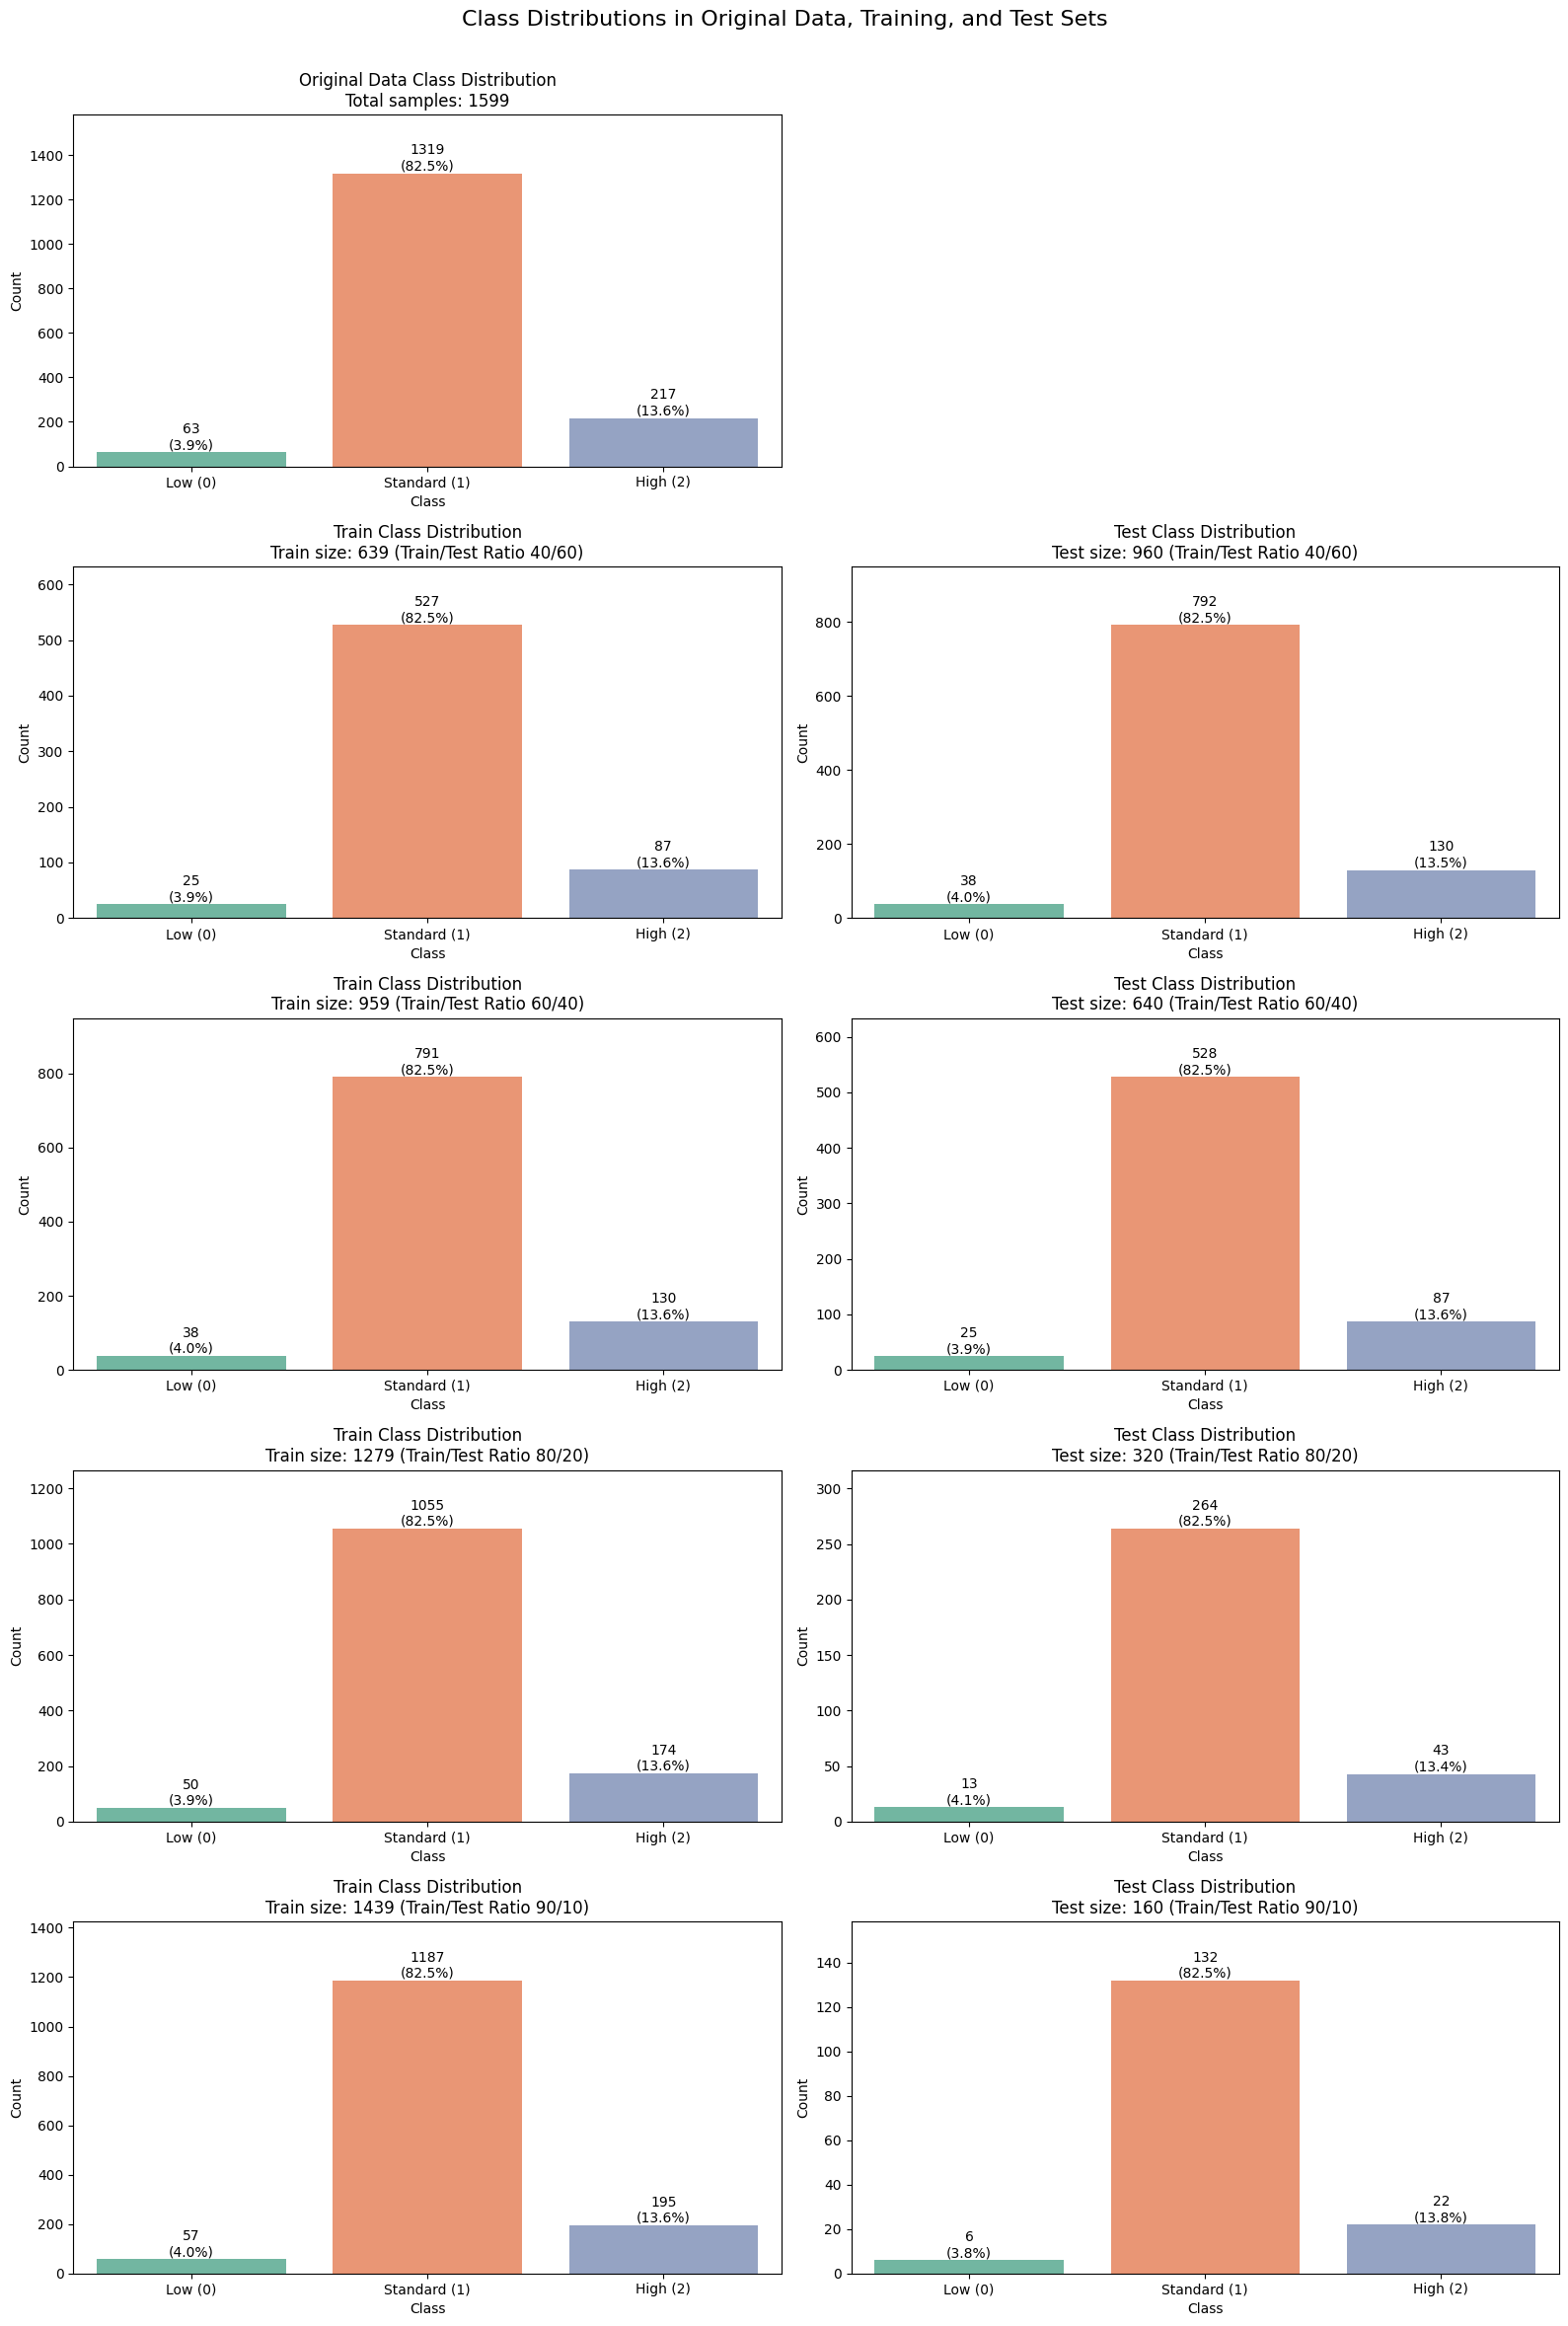

In [4]:
# Function to plot class distributions
def plot_class_distribution(ax, y, title, dataset_name=""):
    unique, counts = np.unique(y, return_counts=True)
    total_samples = sum(counts)
    
    sns.barplot(x=unique, y=counts, hue=unique, ax=ax, palette="Set2", dodge=False, legend=False)
    
    percentages = [f"{(count / total_samples) * 100:.1f}%" for count in counts]
    for i, count in enumerate(counts):
        ax.text(i, count, f"{count}\n({percentages[i]})", ha="center", va="bottom", fontsize=10)
    

    ax.set_title(f"{title}\n{dataset_name}", fontsize=12)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.set_xticks(range(len(unique)))  # Đảm bảo các tick thẳng hàng với cột
    ax.set_xticklabels(["Low (0)", "Standard (1)", "High (2)"])
    ax.set_ylim(0, max(counts) * 1.2)  # Tăng giới hạn trên của trục y để có thêm khoảng trống

# Set up subplots
fig, axes = plt.subplots(len(train_test_ratios) + 1, 2, figsize=(16, 24))
axes = axes.flatten()

# Plot original dataset distribution (in the first row)
plot_class_distribution(axes[0], labels_wine, title="Original Data Class Distribution", dataset_name=f"Total samples: {len(labels_wine)}")
axes[1].axis("off")  # Disable the second subplot in the first row

# Plot distributions for each ratio
for i, ratio in enumerate(train_test_ratios):
    X_train, X_test, y_train, y_test = splits_wine[ratio]

    # Train set distribution
    plot_class_distribution(
        axes[2 * (i + 1)], y_train, 
        title=f"Train Class Distribution", 
        dataset_name=f"Train size: {len(y_train)} (Train/Test Ratio {int(ratio*100)}/{int(round(1-ratio,1)*100)})"
    )
    
    # Test set distribution
    plot_class_distribution(
        axes[2 * (i + 1) + 1], y_test, 
        title=f"Test Class Distribution", 
        dataset_name=f"Test size: {len(y_test)} (Train/Test Ratio {int(ratio*100)}/{int(round(1-ratio,1)*100)})"
    )

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("Class Distributions in Original Data, Training, and Test Sets", fontsize=16, y=0.98)
plt.show()


# **3. XÂY DỰNG BỘ PHÂN LOẠI CÂY QUYẾT ĐỊNH**

In [5]:
def train_and_visualize_decision_tree(features_train, labels_train, max_depth=None):
    dtc = DecisionTreeClassifier(
        criterion='entropy',
        splitter="best", 
        max_depth=max_depth,
        random_state=42)
    
    dtc.fit(features_train, labels_train)
    return dtc

# Initialize an empty list to store Decision Tree models
models: list[DecisionTreeClassifier] = []

# Iterate through each train/test proportion in proportions
for ratio in train_test_ratios:

    features_train, features_test, labels_train, labels_test = splits_wine[ratio]

    # Create a DecisionTreeClassifier instance
    model = train_and_visualize_decision_tree(features_train, labels_train)
    models.append(model)

def visualize_tree(dtc, feature_names, class_names):
    dot_data = export_graphviz(
        dtc, 
        out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True, rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data,format="png")
    return graph

# Iterate over each model and corresponding train/test proportion
for model, ratio in zip(models, train_test_ratios):

    features_train, features_test, labels_train, labels_test = splits_wine[ratio]

    # Vẽ cây quyết định
    graph = visualize_tree(model, feature_names = features_train.columns, class_names = ['Low', 'Standard', 'High'])
    
    # Xuất cây quyết định ra file hình ảnh
    graph.render(f"my_decision_tree_wine_{int(ratio*100)}_{int(round(1-ratio,1)*100)}", format='png', cleanup=True)

# **4. ĐÁNH GIÁ BỘ PHÂN LOẠI CÂY QUYẾT ĐỊNH**

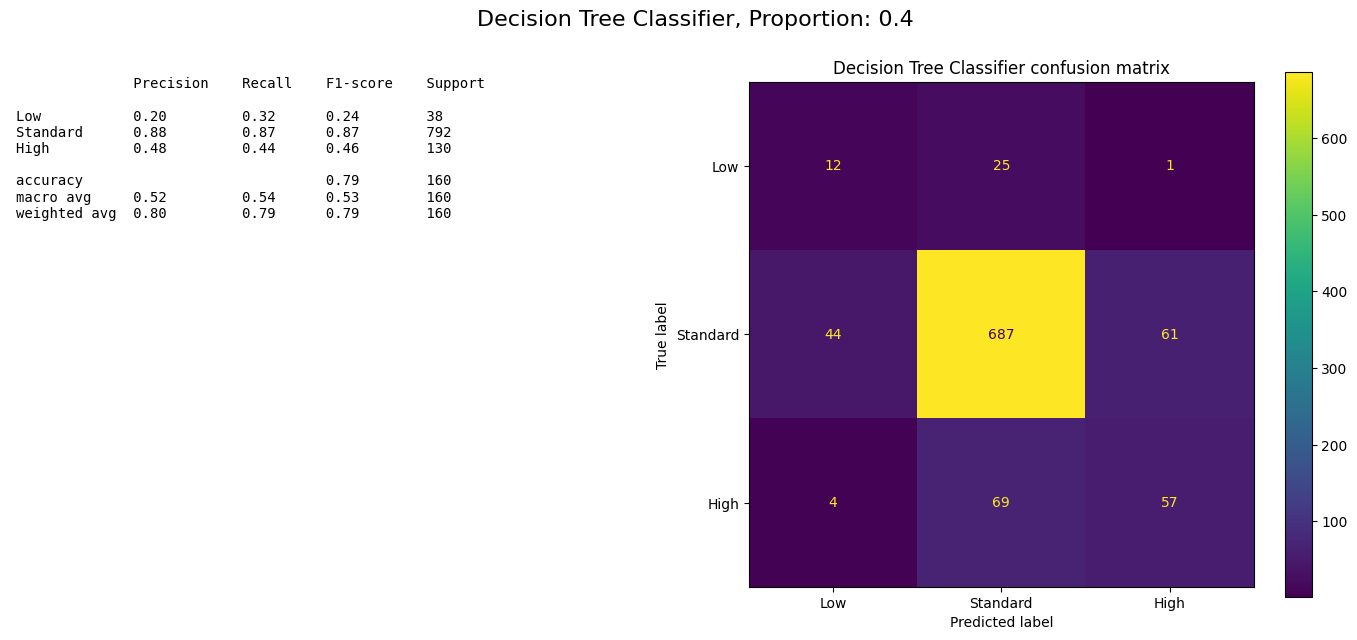

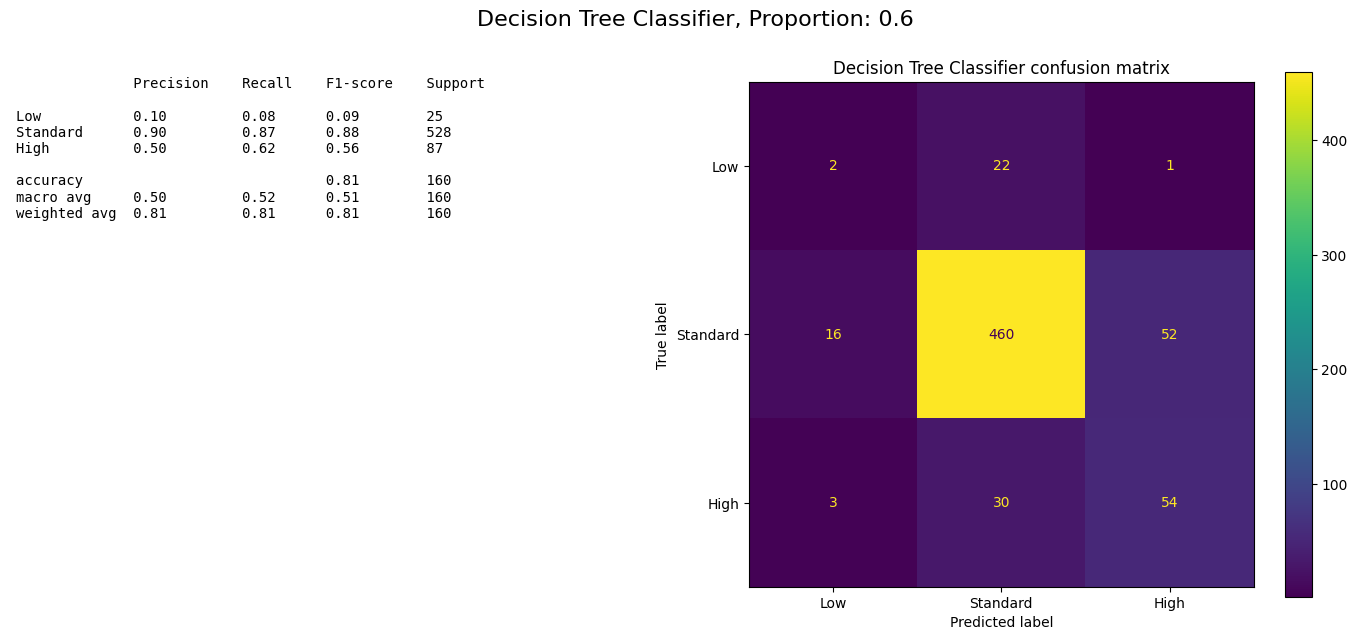

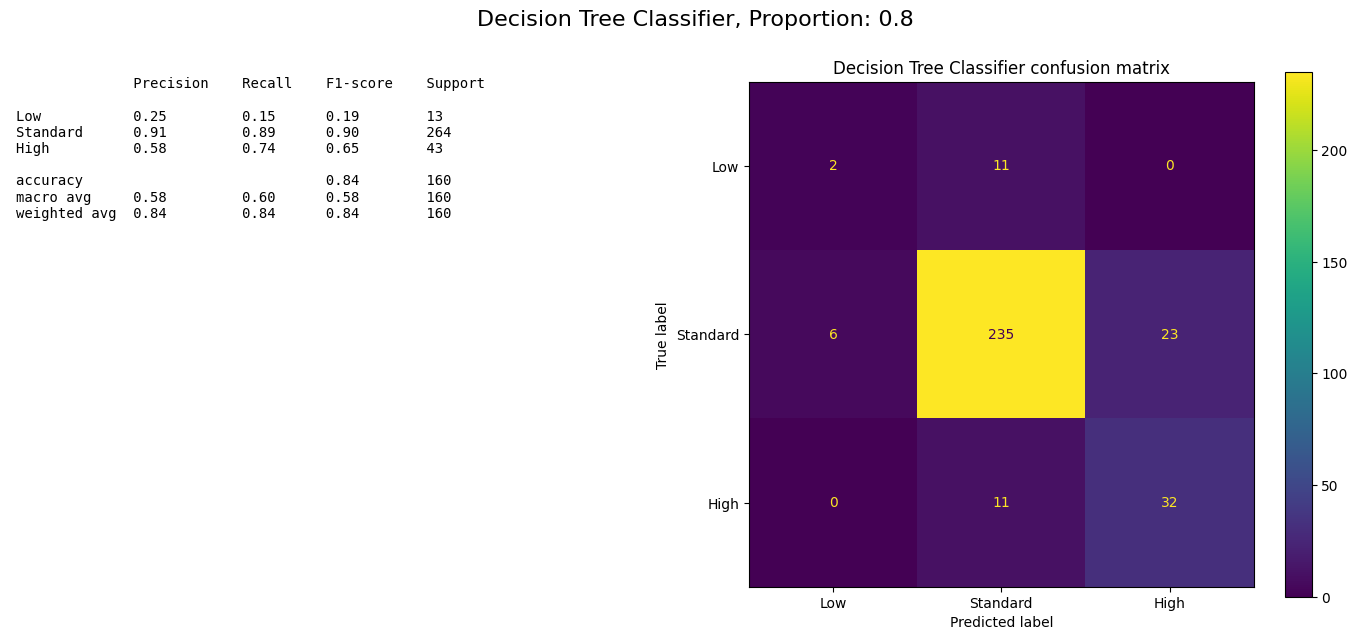

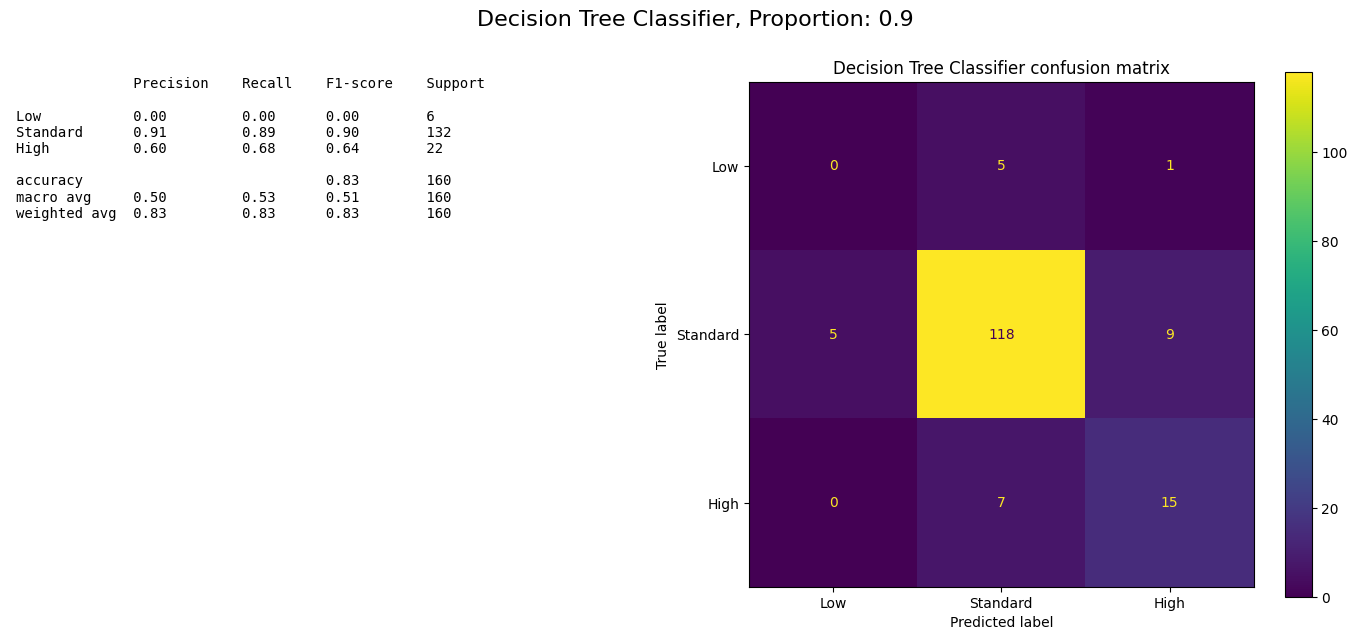

In [6]:
# Loop through models and corresponding train/test proportions
for model, ratio in zip(models, train_test_ratios):
    features_train, features_test, labels_train, labels_test = splits_wine[ratio]
    
    pred = model.predict(features_test) # Predict the labels for the test set
    # Generate a classification report as a dictionary
    report_dict = classification_report(
        labels_test,
        pred,
        target_names=['Low', 'Standard', 'High'],
        output_dict=True
    )

    total_support = len(y_test)
    accuracy_f1_score = report_dict['accuracy']

     # Add header row to the table
    rows = []
    rows.append(["", "Precision", "Recall", "F1-score", "Support"])
    rows.append(["", "", "", "", ""])

    # Add rows for each class ('B' and 'M') with metrics
    for key in ['Low', 'Standard', 'High']:
        rows.append([
            key,
            f"{report_dict[key]['precision']:<8.2f}",
            f"{report_dict[key]['recall']:<8.2f}",
            f"{report_dict[key]['f1-score']:<8.2f}",
            f"{int(report_dict[key]['support']):<8}"
        ])
        if key == 'High':
            rows.append(["", "", "", "", ""])

     # Add a row for accuracy
    rows.append([
        "accuracy",
        "",
        "",
        f"{accuracy_f1_score:<8.2f}",
        f"{total_support:<8}"
    ])

    # Add rows for macro average and weighted average metrics
    for key in ['macro avg', 'weighted avg']:
        rows.append([
            key,
            f"{report_dict[key]['precision']:<8.2f}",
            f"{report_dict[key]['recall']:<8.2f}",
            f"{report_dict[key]['f1-score']:<8.2f}",
            f"{total_support:<8}"
        ])

    # Convert the rows into a formatted table using tabulate
    report_table = tabulate(
        rows,
        headers="firstrow",
        tablefmt="plain",
        numalign="right",
    )

    cm_result = confusion_matrix(labels_test, pred) # Compute the confusion matrix

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Decision Tree Classifier, Proportion: {ratio}", fontsize=16, y=1.02)

    # Display the classification report as text in the first subplot
    axs[0].text(0.01, 0.99, report_table, fontsize=10, ha='left', va='top', family="monospace")
    axs[0].axis('off')

    # Display the confusion matrix in the second subplot
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_result, display_labels=['Low', 'Standard', 'High'])
    cm_display.plot(ax=axs[1])
    axs[1].set_title('Decision Tree Classifier confusion matrix')

    plt.tight_layout()  # Adjust layout to ensure subplots do not overlap
    plt.show()

    

# **5. ĐỘ SÂU VÀ CHÍNH XÁC CỦA CÂY QUYẾT ĐỊNH**

## **5.1. TRỰC QUAN HÓA CÂY QUYẾT ĐỊNH VỚI MỖI ĐỘ SÂU**

In [9]:
# Define values for parameter max_depth
max_depths = [None, 2, 3, 4, 5, 6, 7]

# Initialize an empty list to store accuracy results for each depth
accuracy_results = []

features_train, features_test, labels_train, labels_test = splits_wine[0.8]

# Loop through different max_depth values
for depth in max_depths:

    # Initialize the DecisionTreeClassifier
    model = train_and_visualize_decision_tree(features_train, labels_train, depth)

    label_pred = model.predict(features_test)  # Predict the labels for the test data
    tree_test = accuracy_score(labels_test, label_pred) # Calculate the accuracy of the model
    accuracy_results.append([str(depth), f"{tree_test:.3f}"])  # Append the depth and the accuracy
    
     # Vẽ cây quyết định
    graph = visualize_tree(model, feature_names = features_train.columns, class_names = ['Low', 'Standard', 'High'])

    # Xuất cây quyết định ra file hình ảnh
    graph.render(f"my_decision_tree_wine_80_20_with_depth_{depth}", format='png', cleanup=True)


# **4.2. BIỂU ĐỒ VÀ BÁO CÁO THÔNG TIN SỐ LIỆU**

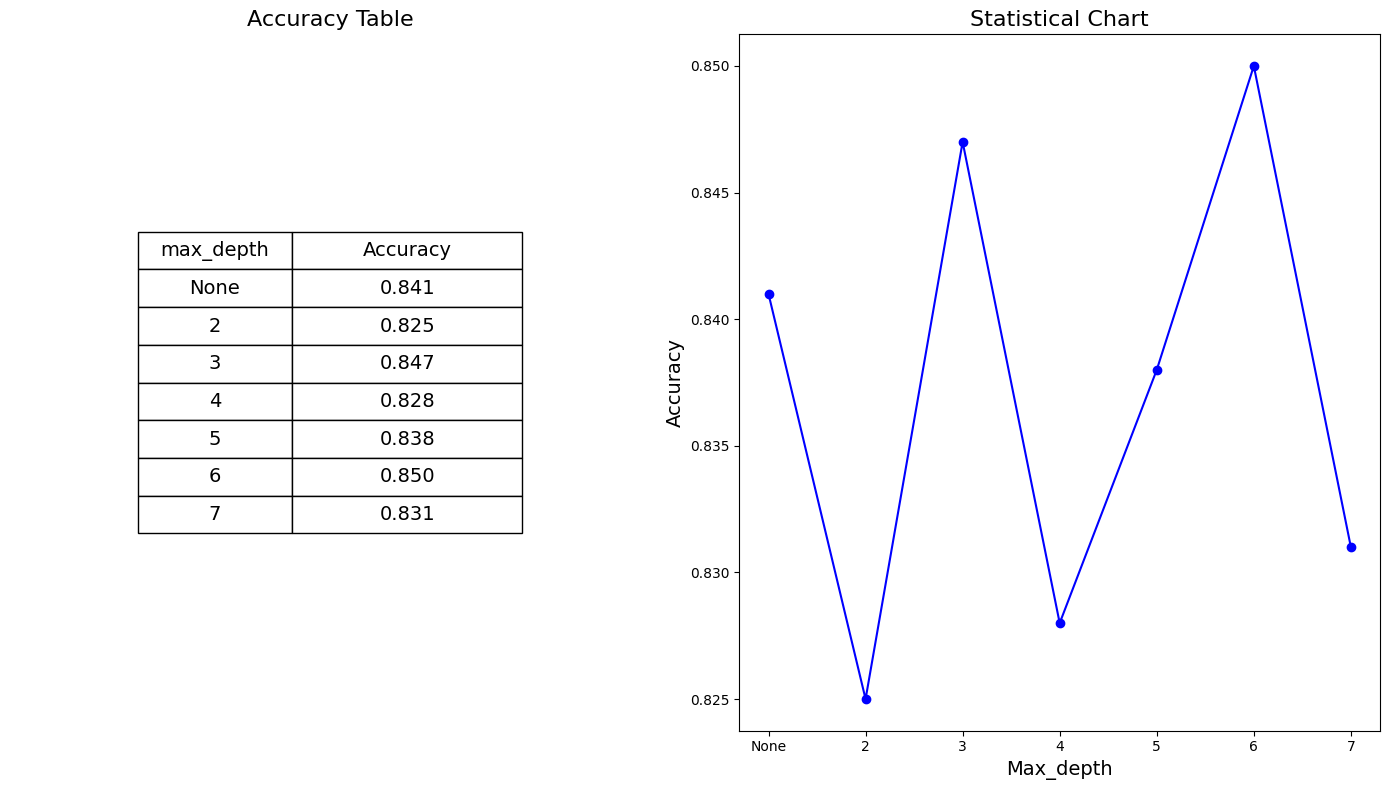

In [8]:
# Convert the accuracy_results into lists for plotting
depth_values = [str(item[0]) for item in accuracy_results]
accuracy_values = [float(item[1]) for item in accuracy_results]

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

# Create a table on the first subplot (axs[0])
table = axs[0].table(
    cellText=accuracy_results,
    colLabels=["max_depth", "Accuracy"],
    loc="center",
    cellLoc="center",
    colWidths=[0.2, 0.3],
    fontsize=14
)

axs[0].axis("off")
axs[0].set_title("Accuracy Table", fontsize=16)

# Adjust the font size and scale of the table
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 2)

axs[1].plot(depth_values, accuracy_values, marker='o', linestyle='-', color='b') # Plot the statistical chart

# Set the title and labels for the second subplot
axs[1].set_title('Statistical Chart', fontsize=16)
axs[1].set_xlabel('Max_depth', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)

plt.tight_layout() # Adjust the layout to avoid overlap
plt.show() # Display the plots